# Implementing coordinate-transformed hermite polynomials

In [1]:
#  Automated import
import sys
import os
sys.path.append('..')

from hg_scripts.setup_imports import *


In [2]:
#order a^#*b^#
working = 1
crossterm_order = working*2+1

In [6]:
waist = (1/3)*1e-3
plotOrNot = False
top_modes=coeff_from_mat('paul_coef_file.mat',waist,plotOrNot)



In [7]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes,s):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,s) )
                
    return(res)

In [8]:
def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave1 = 0
    time_ave2 = 0

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points
    total_lps = [0]*points
    

    #alpha_arr = np.linspace(-500e-6,500e-6,points)
    

    pbar = ProgressBar(widgets=[Percentage(), Bar()], maxval=points).start()

    
    
    for p in range(points):
        time_ave_start1 = process_time()
        #shift x+zsina
        new_modes = update_modes(v.z,v.params,v.a,v.alpha_arr[p],top_modes,sols_matrix)
        
        time_ave_start2 = process_time()
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes,v.s) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes,v.s) # right overlap (0,2e-3)
        time_ave1 += (process_time()-time_ave_start1)
        time_ave2 += (process_time()-time_ave_start2)
        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])/v.k_1
        total_lps[p] = angle(cr[p]+cl[p])/v.k_1
        
        pbar.update(p+1)
        
    pbar.finish()
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave1/p,'s',time_ave2/p,'s')
    
    return(dws,lps,total_lps)

num=11


class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=10e-3,z=10e-3,
                 z_m=0,Z=10e-3,
                 z_LO=0, d_1=10e-3,
#                  z_PD=0,z=0,
#                  z_m=0,Z=0,
#                  z_LO=0, d_1=0,
                 Y=20e-3,
                 x_1R=10e-6,x_2R=20e-3,
                 x_1L=-20e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=waist,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*waist**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,waist,0),
                 W_2=1e-3,
                 points=num,
                 a=10e-6,alpha_arr=np.linspace(-500e-6,500e-6,num),modes_arr=[0]*num):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0)) #tophat beam rad , w(z) or 1e-3?
    
        self.s= (
                1/(w_1**2 *(1+(1j)*d_1/zR_1))
                +
                1/((w_2**2 *(1-(1j)*Z/zR_2)))
            )

        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
#         for p in range (points):
#             self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_matrix) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,waist,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = update_modes(z,params,a,alpha_arr[p],modes_0,sols_arr) #array of array of scattered modes#array of array of scattered modes

        


In [9]:
modes_0 = plb.modes((0,0,1))



# z=10e-3
# params = pl.Params(1064e-9,1e-3,z)


print('Signals calculation...')
v = Vars()
dws,lps,total_lps = signals(v)


params=pl.Params(1064e-9,waist,0)
K=params.getK()



Signals calculation...


11.015625 s
1.1 s 0.978125 s


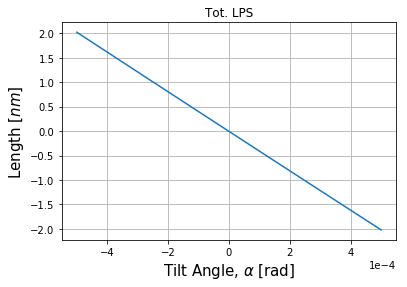

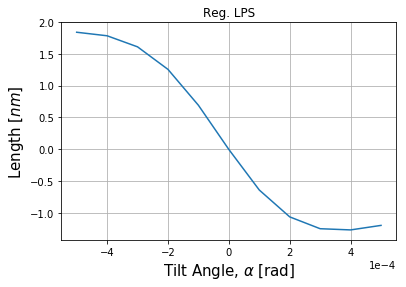

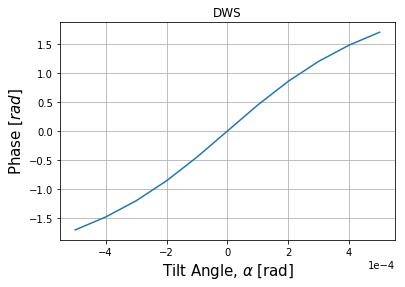

In [10]:
total_arr = np.array(total_lps)
total_arr_con = total_arr*1e9

lps_arr = np.array(lps)
lps_arr_con = lps_arr*1e9

plot_lpsT(v.alpha_arr,total_arr_con)
plot_lpsR(v.alpha_arr,lps_arr_con)
plot_dws(v.alpha_arr,dws)


In [11]:
lps = lps_arr_con; total_lps = total_arr_con;

dws_slope = np.zeros(len(dws),np.float)
dws_slope[0:-1] = np.diff(dws)/np.diff(v.alpha_arr)
dws_slope[-1] = (dws[-1] - dws[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
lps_slope = np.zeros(len(lps),np.float)
lps_slope[0:-1] = np.diff(lps)/np.diff(v.alpha_arr)
lps_slope[-1] = (lps[-1] - lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])
total_lps_slope = np.zeros(len(total_lps),np.float)
total_lps_slope[0:-1] = np.diff(total_lps)/np.diff(v.alpha_arr)
total_lps_slope[-1] = (total_lps[-1] - total_lps[-2])/(v.alpha_arr[-1] - v.alpha_arr[-2])




# ###############################################
# note = ('1_shift_'+str(working)+'_10mmoff_'+str(working)+'_'+str(working))

# scipy.io.savemat('tophat'+note+'.mat', mdict={'angle': v.alpha_arr, 'lps'+note: lps, 'total_lps'+note: total_lps,'dws_HG00'+note: dws,
#                                          'lps_slope'+note: lps_slope, 'total_lps_slope'+note : total_lps_slope,
#                                         'dws_slope'+note: dws_slope})

# print(v.alpha_arr)